# Project Part 3
### Marco Meraz
### Hate Speech Detection
In this part of the project we will train our dataset with a deep learning model.
To carry out our task of hate speech classification, we will use the pretrained model Roberta. I feel that using a pretrained model on my dataset
will be benefitial as the dataset is relatively small. 

In [1]:
# All necessary imports.
import numpy as np
import pandas as pd
import torch
import os
from transformers import RobertaTokenizer, RobertaModel, RobertaForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, load_metric

df = pd.read_csv('youtoxic_english_1000.csv')
df = df[['Text','IsToxic']].copy()
df.head()

,Text,IsToxic
0,If only people would just take a step back and...,False
1,Law enforcement is not trained to shoot to app...,True
2,\nDont you reckon them 'black lives matter' ba...,True
3,There are a very large number of people who do...,False
4,"The Arab dude is absolutely right, he should h...",False


The section below sets 10% of the dataset for testing later in the project.

In [2]:
df_train_and_val = df[:int(0.9*len(df))]
df_test = df[int(0.9*len(df)):] #10% of dataset for testing
print(f"df_train_and_val.shape:  {df_train_and_val.shape}")
print(f"df_test.shape:  {df_test.shape}")

df_train_and_val.shape:  (900, 2)
df_test.shape:  (100, 2)


The model we are using on our dataset will be the pretrained model roberta.

In [3]:
MODEL_NAME = 'roberta-base'
MAX_LENGTH = 50

tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=2,max_length=MAX_LENGTH)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

Our dataset has two classifications for every comment made on YouTube about the Furgenson unrest of 2014. The comment is either true or false if the comment is toxic.

In [4]:
classes = df_train_and_val.IsToxic.unique().tolist()
class_tok2idx = dict((v, k) for k, v in enumerate(classes))
class_idx2tok = dict((k, v) for k, v in enumerate(classes))
print(class_tok2idx)
print(class_idx2tok)

{False: 0, True: 1}
{0: False, 1: True}


In [5]:
df_train_and_val['label'] = df_train_and_val['IsToxic'].apply(lambda x: class_tok2idx[x])
df_train_and_val.head()

/var/folders/zc/w3_gp3bj2r75g6hkvhz1zd4w0000gn/T/ipykernel_3046/2991571106.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_and_val['label'] = df_train_and_val['IsToxic'].apply(lambda x: class_tok2idx[x])


,Text,IsToxic,label
0,If only people would just take a step back and...,False,0
1,Law enforcement is not trained to shoot to app...,True,1
2,\nDont you reckon them 'black lives matter' ba...,True,1
3,There are a very large number of people who do...,False,0
4,"The Arab dude is absolutely right, he should h...",False,0


In [6]:
ds_raw = Dataset.from_pandas(df_train_and_val[['label','Text']])
ds_raw[0]

{'label': 0,
 'Text': "If only people would just take a step back and not make this case about them, because it wasn't about anyone except the two people in that situation.\xa0 To lump yourself into this mess and take matters into your own hands makes these kinds of protests selfish and without rational thought and investigation.\xa0 The guy in this video is heavily emotional and hyped up and wants to be heard, and when he gets heard he just presses more and more.\xa0 He was never out to have a reasonable discussion.\xa0 Kudos to the Smerconish for keeping level the whole time and letting Masri make himself out to be a fool.\xa0 How dare he and those that tore that city down in protest make this about themselves and to dishonor the entire incident with their own hate.\xa0 By the way, since when did police brutality become an epidemic?\xa0 I wish everyone would just stop pretending like they were there and they knew EXACTLY what was going on, because there's no measurable amount of peop

In [7]:
def tokenize_function(examples):
    return tokenizer(examples["Text"], padding="max_length", truncation=True, max_length=MAX_LENGTH)

ds = ds_raw.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [8]:
ds[0]

{'label': 0,
 'Text': "If only people would just take a step back and not make this case about them, because it wasn't about anyone except the two people in that situation.\xa0 To lump yourself into this mess and take matters into your own hands makes these kinds of protests selfish and without rational thought and investigation.\xa0 The guy in this video is heavily emotional and hyped up and wants to be heard, and when he gets heard he just presses more and more.\xa0 He was never out to have a reasonable discussion.\xa0 Kudos to the Smerconish for keeping level the whole time and letting Masri make himself out to be a fool.\xa0 How dare he and those that tore that city down in protest make this about themselves and to dishonor the entire incident with their own hate.\xa0 By the way, since when did police brutality become an epidemic?\xa0 I wish everyone would just stop pretending like they were there and they knew EXACTLY what was going on, because there's no measurable amount of peop

In [9]:
ds = ds.shuffle(seed=42)
ds[0]

{'label': 0,
 'Text': 'Thank you +Stefan Molyneux\xa0 for sharing your logical and rational evaluation of the occurrences of this incident.',
 'input_ids': [0,
  13987,
  47,
  2055,
  21426,
  19302,
  256,
  15022,
  858,
  7073,
  50141,
  13,
  3565,
  110,
  16437,
  8,
  15699,
  10437,
  9,
  5,
  39036,
  9,
  42,
  1160,
  4,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

## Training and Validation
We will set aside 90% of our dataset, and 10% for validation.
Reminder, the dataset was cut 100 observations at the beginning for testing.

In [10]:
train_prop = 0.85
ds_train = ds.select(range(int(len(ds)*train_prop)))
ds_eval = ds.select(range(int(len(ds)*train_prop), len(ds)))

In [11]:

os.environ["WANDB_DISABLED"] = "true"
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(num_train_epochs=4, 
                                  do_train=True,
                                  report_to=None,
                                  output_dir="working",
                                  evaluation_strategy="steps",
                                  eval_steps=500,
                                  per_device_train_batch_size=10,
                                  per_device_eval_batch_size=10,
                                  optim="adamw_torch"
                                  )

trainer = Trainer(model = model, 
                  args = training_args,
                  train_dataset = ds_train, 
                  eval_dataset = ds_eval,
                  compute_metrics = compute_metrics,
)

torch.set_grad_enabled(True)
train = trainer.train()
eval = trainer.evaluate()

/var/folders/zc/w3_gp3bj2r75g6hkvhz1zd4w0000gn/T/ipykernel_3046/2027069047.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 765
  Num Epochs = 4
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total 

  0%|          | 0/308 [00:00<?, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 135
  Batch size = 10


{'train_runtime': 224.6956, 'train_samples_per_second': 13.618, 'train_steps_per_second': 1.371, 'train_loss': 0.38146145312817065, 'epoch': 4.0}


  0%|          | 0/14 [00:00<?, ?it/s]

In [12]:
# print(train)
# print(eval)
print("train_loss: "+ str(train[2]['train_loss']) + ", eval_loss: " + str(eval['eval_loss']))
print("eval_accuracy: " + str(eval['eval_accuracy']))

train_loss: 0.38146145312817065, eval_loss: 0.7335344552993774
eval_accuracy: 0.8296296296296296


In [15]:
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

def tuneModel(hp_value):
    os.environ["WANDB_DISABLED"] = "true"
    metric = load_metric("accuracy")

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return metric.compute(predictions=predictions, references=labels)

    training_args = TrainingArguments(num_train_epochs=hp_value, 
                                    do_train=True,
                                    report_to=None,
                                    output_dir="working",
                                    evaluation_strategy="steps",
                                    eval_steps=500,
                                    per_device_train_batch_size=10,
                                    per_device_eval_batch_size=10,
                                    optim="adamw_torch"
                                    )

    trainer = Trainer(model = model, 
                    args = training_args,
                    train_dataset = ds_train, 
                    eval_dataset = ds_eval,
                    compute_metrics = compute_metrics,
    )

    torch.set_grad_enabled(True)
    train = trainer.train()
    eval = trainer.evaluate()    
    return (train[2]['train_loss'],eval['eval_loss'],eval['eval_accuracy'])

def loss_and_accuracy_plot(metrics, hyp_param_vals,x_label):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

    ax1.set_xticks(hyp_param_vals)
    ax1.set(xlabel=x_label, ylabel="loss (lower is better)")
    ax1.plot(hyp_param_vals, [metric[1] for metric in metrics], '--ro') # validation loss
    ax1.plot(hyp_param_vals, [metric[0] for metric in metrics], '--bo') # training loss
    ax1.legend(["Validation Loss", "Train Loss"], loc=1)

    ax2.set_xticks(hyp_param_vals)
    ax2.set(xlabel=x_label, ylabel="accuracy (higher is better)")
    #ax2.plot(hyp_param_vals, [metric[3] for metric in metrics], '--ro') # validation accuracy
    ax2.plot(hyp_param_vals, [metric[2] for metric in metrics], '--bo') # training accuracy
    ax2.legend(["Validation Accuracy", "Train Accuracy"], loc=4)

We will train our model with different number of epochs to see the best number of epochs for our dataset.

In [16]:
n_hyp_param_values = list(range(1,30,5))
metrics = []

for hp in n_hyp_param_values:
    metrics.append(tuneModel(hp))



PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 810
  Num Epochs = 1
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps 

  0%|          | 0/81 [00:00<?, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 90
  Batch size = 10


{'train_runtime': 59.8352, 'train_samples_per_second': 13.537, 'train_steps_per_second': 1.354, 'train_loss': 0.2744650664152922, 'epoch': 1.0}


  0%|          | 0/9 [00:00<?, ?it/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 810
  Num Epochs = 6
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps 

  0%|          | 0/486 [00:00<?, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 90
  Batch size = 10


{'train_runtime': 358.2899, 'train_samples_per_second': 13.564, 'train_steps_per_second': 1.356, 'train_loss': 0.09991683489010658, 'epoch': 6.0}


  0%|          | 0/9 [00:00<?, ?it/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 810
  Num Epochs = 11
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps

  0%|          | 0/891 [00:00<?, ?it/s]

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 90
  Batch size = 10


{'loss': 0.0729, 'learning_rate': 2.1941638608305277e-05, 'epoch': 6.17}


  0%|          | 0/9 [00:00<?, ?it/s]

Saving model checkpoint to working/checkpoint-500
Configuration saved in working/checkpoint-500/config.json


{'eval_loss': 1.2258352041244507, 'eval_accuracy': 0.8222222222222222, 'eval_runtime': 1.6504, 'eval_samples_per_second': 54.531, 'eval_steps_per_second': 5.453, 'epoch': 6.17}


Model weights saved in working/checkpoint-500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 90
  Batch size = 10


{'train_runtime': 659.3156, 'train_samples_per_second': 13.514, 'train_steps_per_second': 1.351, 'train_loss': 0.043682554354169956, 'epoch': 11.0}


  0%|          | 0/9 [00:00<?, ?it/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 810
  Num Epochs = 16
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps

  0%|          | 0/1296 [00:00<?, ?it/s]

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 90
  Batch size = 10


{'loss': 0.1107, 'learning_rate': 3.0709876543209876e-05, 'epoch': 6.17}


  0%|          | 0/9 [00:00<?, ?it/s]

Saving model checkpoint to working/checkpoint-500
Configuration saved in working/checkpoint-500/config.json


{'eval_loss': 1.118552803993225, 'eval_accuracy': 0.8333333333333334, 'eval_runtime': 1.6675, 'eval_samples_per_second': 53.974, 'eval_steps_per_second': 5.397, 'epoch': 6.17}


Model weights saved in working/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 90
  Batch size = 10


{'loss': 0.0203, 'learning_rate': 1.1419753086419753e-05, 'epoch': 12.35}


  0%|          | 0/9 [00:00<?, ?it/s]

Saving model checkpoint to working/checkpoint-1000
Configuration saved in working/checkpoint-1000/config.json


{'eval_loss': 1.2592432498931885, 'eval_accuracy': 0.8333333333333334, 'eval_runtime': 1.6397, 'eval_samples_per_second': 54.889, 'eval_steps_per_second': 5.489, 'epoch': 12.35}


Model weights saved in working/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 90
  Batch size = 10


{'train_runtime': 962.9785, 'train_samples_per_second': 13.458, 'train_steps_per_second': 1.346, 'train_loss': 0.0531454211399879, 'epoch': 16.0}


  0%|          | 0/9 [00:00<?, ?it/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 810
  Num Epochs = 21
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps

  0%|          | 0/1701 [00:00<?, ?it/s]

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 90
  Batch size = 10


{'loss': 0.0491, 'learning_rate': 3.530276308054086e-05, 'epoch': 6.17}


  0%|          | 0/9 [00:00<?, ?it/s]

Saving model checkpoint to working/checkpoint-500
Configuration saved in working/checkpoint-500/config.json


{'eval_loss': 1.536906123161316, 'eval_accuracy': 0.7888888888888889, 'eval_runtime': 1.836, 'eval_samples_per_second': 49.019, 'eval_steps_per_second': 4.902, 'epoch': 6.17}


Model weights saved in working/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 90
  Batch size = 10


{'loss': 0.0189, 'learning_rate': 2.0605526161081718e-05, 'epoch': 12.35}


  0%|          | 0/9 [00:00<?, ?it/s]

Saving model checkpoint to working/checkpoint-1000
Configuration saved in working/checkpoint-1000/config.json


{'eval_loss': 1.6565876007080078, 'eval_accuracy': 0.7888888888888889, 'eval_runtime': 1.6807, 'eval_samples_per_second': 53.549, 'eval_steps_per_second': 5.355, 'epoch': 12.35}


Model weights saved in working/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 90
  Batch size = 10


{'loss': 0.0016, 'learning_rate': 5.908289241622575e-06, 'epoch': 18.52}


  0%|          | 0/9 [00:00<?, ?it/s]

Saving model checkpoint to working/checkpoint-1500
Configuration saved in working/checkpoint-1500/config.json


{'eval_loss': 1.7944369316101074, 'eval_accuracy': 0.8111111111111111, 'eval_runtime': 1.8037, 'eval_samples_per_second': 49.898, 'eval_steps_per_second': 4.99, 'epoch': 18.52}


Model weights saved in working/checkpoint-1500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 90
  Batch size = 10


{'train_runtime': 1268.9676, 'train_samples_per_second': 13.405, 'train_steps_per_second': 1.34, 'train_loss': 0.021455382263569325, 'epoch': 21.0}


  0%|          | 0/9 [00:00<?, ?it/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 810
  Num Epochs = 26
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps

  0%|          | 0/2106 [00:00<?, ?it/s]

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 90
  Batch size = 10


{'loss': 0.0, 'learning_rate': 3.8129154795821466e-05, 'epoch': 6.17}


  0%|          | 0/9 [00:00<?, ?it/s]

Saving model checkpoint to working/checkpoint-500
Configuration saved in working/checkpoint-500/config.json


{'eval_loss': 2.792567729949951, 'eval_accuracy': 0.8333333333333334, 'eval_runtime': 1.5996, 'eval_samples_per_second': 56.263, 'eval_steps_per_second': 5.626, 'epoch': 6.17}


Model weights saved in working/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 90
  Batch size = 10


{'loss': 0.0, 'learning_rate': 2.6258309591642926e-05, 'epoch': 12.35}


  0%|          | 0/9 [00:00<?, ?it/s]

Saving model checkpoint to working/checkpoint-1000
Configuration saved in working/checkpoint-1000/config.json


{'eval_loss': 2.9169132709503174, 'eval_accuracy': 0.8222222222222222, 'eval_runtime': 1.6064, 'eval_samples_per_second': 56.026, 'eval_steps_per_second': 5.603, 'epoch': 12.35}


Model weights saved in working/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 90
  Batch size = 10


{'loss': 0.0, 'learning_rate': 1.4387464387464389e-05, 'epoch': 18.52}


  0%|          | 0/9 [00:00<?, ?it/s]

Saving model checkpoint to working/checkpoint-1500
Configuration saved in working/checkpoint-1500/config.json


{'eval_loss': 2.985468626022339, 'eval_accuracy': 0.8222222222222222, 'eval_runtime': 1.6642, 'eval_samples_per_second': 54.08, 'eval_steps_per_second': 5.408, 'epoch': 18.52}


Model weights saved in working/checkpoint-1500/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 90
  Batch size = 10


{'loss': 0.0232, 'learning_rate': 2.51661918328585e-06, 'epoch': 24.69}


  0%|          | 0/9 [00:00<?, ?it/s]

Saving model checkpoint to working/checkpoint-2000
Configuration saved in working/checkpoint-2000/config.json


{'eval_loss': 2.0665392875671387, 'eval_accuracy': 0.8222222222222222, 'eval_runtime': 1.9846, 'eval_samples_per_second': 45.35, 'eval_steps_per_second': 4.535, 'epoch': 24.69}


Model weights saved in working/checkpoint-2000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 90
  Batch size = 10


{'train_runtime': 1534.0283, 'train_samples_per_second': 13.729, 'train_steps_per_second': 1.373, 'train_loss': 0.005505163282351442, 'epoch': 26.0}


  0%|          | 0/9 [00:00<?, ?it/s]

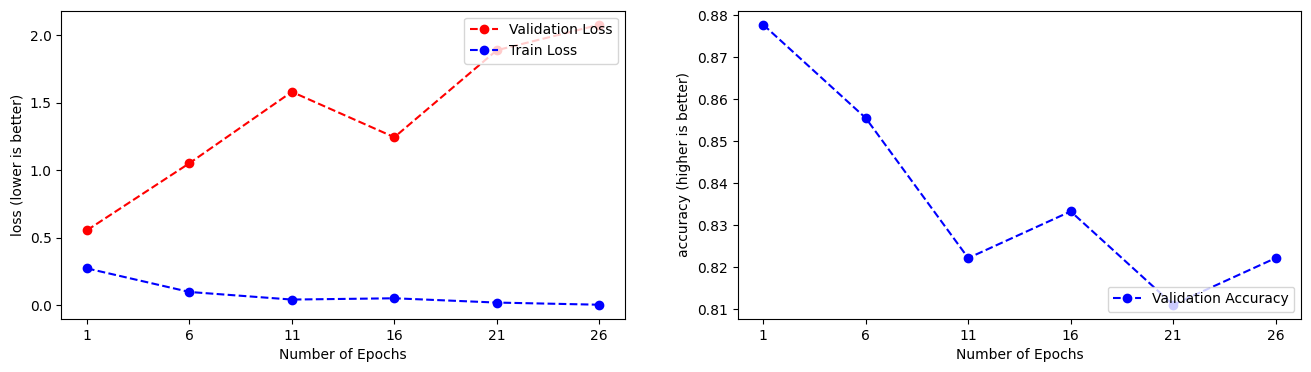

In [17]:
loss_and_accuracy_plot(metrics, n_hyp_param_values,"Number of Epochs")

After training on different number of epochs, it seems that our first run with four epochs was had much better accuracy. Maybe because the dataset is small.

### Testing
With the subset of data we set aside at the beginning we are going to test how well it does on previously not seen data.

In [13]:
ds_test_raw = Dataset.from_pandas(df_test)
ds_test_raw[0]

{'Text': "Oh man, you thug life types...you're hilarious. Seriously, you're a fuckin' riot.\n\nLook, take your three dollar pocket knife back to the pawnshop, pull up your pants, stop playing basstracks in some 80s Sedan with rims that cost more than the car itself and sit your ass back in the office where you belong.\n\nThe criminal life ain't for you.",
 'IsToxic': True}

In [14]:
ds_test = ds_test_raw.map(tokenize_function,batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [15]:
preds = trainer.predict(test_dataset=ds_test)

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text, IsToxic. If Text, IsToxic are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 100
  Batch size = 10


  0%|          | 0/10 [00:00<?, ?it/s]

In [16]:
test_preds = np.apply_along_axis(np.argmax, 1, preds.predictions)
df_test['preds'] = test_preds.tolist()
#df_test['IsToxic'] = df_test['preds'].apply(lambda x: class_idx2tok[x])
df_test[['Text','preds','IsToxic']].head(10)

/var/folders/zc/w3_gp3bj2r75g6hkvhz1zd4w0000gn/T/ipykernel_3046/4162338854.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['preds'] = test_preds.tolist()


,Text,preds,IsToxic
900,"Oh man, you thug life types...you're hilarious...",1,True
901,7:24 7:30 XDDDDDDDDDDDDDDDD,0,False
902,The shooting had not one thing to do with him ...,0,True
903,Blacks get my prejudice easily,1,True
904,Remember that time every other race rioted bec...,0,True
905,didnt he attack a police officer? and steal fr...,0,False
906,"0:10 legend has it that he is still yelling ""m...",0,False
907,Truth is. That the people need to realize and ...,0,False
908,Darude...............sand...storm.......,0,False
909,Just finished the video....\nNow to gaze upon ...,1,True


accuracy (on text_test): 0.7500


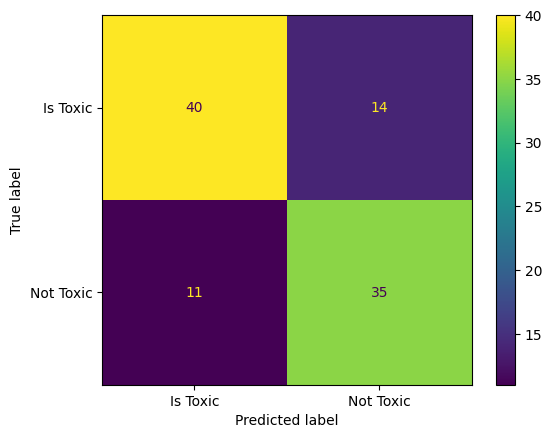

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

display = ConfusionMatrixDisplay(confusion_matrix(df_test['IsToxic'], test_preds),
display_labels=['Is Toxic', 'Not Toxic'])
display.plot()
print(f"accuracy (on text_test): {accuracy_score(df_test['IsToxic'],test_preds):.4f}")

Final thoughts: I think, that the dataset needed to be a bigger for a deep learning model. A traditional machine learning model would be fine for the dataset.